# Create a Siamese Network with Triplet Loss in Keras

# Task 1: Understanding the Approach

In [1]:
# %matplotlib notebook

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

from pca_plotter import PCAPlotter

## Understanding the Approach

This appraoch is taken from the popular [FaceNet](https://arxiv.org/abs/1503.03832) paper.

We have a CNN model called `EmbeddingModel`:

![CNN](assets/CNN.png)

We use three images for each training example:
1. `person1_image1.jpg` (Anchor Example, represented below in green)
2. `person1_image2.jpg` (Positive Example, in blue)
3. `person2_image1.jpg` (Negative Example, in red).

![Embeddings](assets/embeddings.png)


## Siamese Network

All the three images of an example pass through the model, and we get the three Embeddings: One for the Anchor Example, one for the Positive Example, and one for the Negative Example.

![Siamese Network](assets/siamese.png)

The three instances of the `EmbeddingModel` shown above are not different instances. It's the same, shared model instance - i.e. the parameters are shared, and are updated for all the three paths simultaneously.

# Task 2: Importing the Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)

(60000, 28, 28)


In [3]:
x_train = np.reshape(x_train, (x_train.shape[0], 784))/255.
x_test = np.reshape(x_test, (x_test.shape[0], 784))/255.
print(x_train.shape)

(60000, 784)


# Task 3: Plotting Examples

In [4]:
def plot_triplets(examples):
    plt.figure(figsize = (6, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (28, 28)), cmap = 'binary')
        plt.xticks([])
        plt.yticks([])
    plt.show()

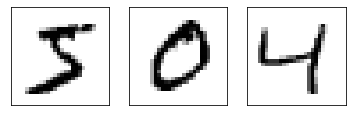

In [5]:
plot_triplets([x_train[0], x_train[1], x_train[2]])

# Task 4: A Batch of Triplets

In [6]:
def create_batch(batch_size=256):
    x_anchors = np.zeros((batch_size, 784))
    x_positives = np.zeros((batch_size, 784))
    x_negatives = np.zeros((batch_size, 784))
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x_train.shape[0] - 1)
        x_anchor = x_train[random_index]
        y = y_train[random_index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))
           
        x_positive = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

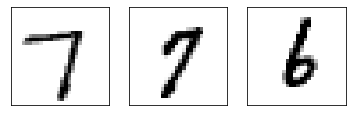

In [7]:
examples = create_batch(1)
plot_triplets(examples)

# Task 5: Embedding Model

In [8]:
emb_size = 64

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation = 'relu', input_shape = (784, )),
    tf.keras.layers.Dense(emb_size, activation = 'sigmoid')
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


In [9]:
example = np.expand_dims(x_train[0], axis = 0)
example_emb = embedding_model.predict(example)[0]

print(example_emb)

[0.5102276  0.60359716 0.48702595 0.6796945  0.5145269  0.53561187
 0.6136286  0.5908035  0.48257688 0.5600274  0.4293328  0.4881589
 0.43933317 0.5204259  0.48129752 0.70447516 0.48218083 0.61642176
 0.39814922 0.535914   0.52586555 0.4395444  0.5925775  0.53775305
 0.6509847  0.5641451  0.5423618  0.43038836 0.42922285 0.49094835
 0.43615457 0.5543933  0.37717447 0.49834862 0.5627447  0.37310976
 0.57122105 0.43674168 0.56165767 0.39383882 0.5600021  0.6247083
 0.40369624 0.5141269  0.46309513 0.68824464 0.45350704 0.4057635
 0.48800406 0.41145244 0.51595265 0.4995887  0.62316495 0.4004115
 0.54272854 0.48616502 0.5559963  0.6823884  0.4669516  0.5850137
 0.36895764 0.48481107 0.6138688  0.5006189 ]


# Task 6: Siamese Network

In [10]:
input_anchor = tf.keras.layers.Input(shape = (784,))
input_positive = tf.keras.layers.Input(shape = (784,))
input_negative = tf.keras.layers.Input(shape = (784,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           54400       input_1[0][0]                    
                                                                 input_2[0][0]                

# Task 7: Triplet Loss

A loss function that tries to pull the Embeddings of Anchor and Positive Examples closer, and tries to push the Embeddings of Anchor and Negative Examples away from each other.

Root mean square difference between Anchor and Positive examples in a batch of N images is:
$
\begin{equation}
d_p = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(p_i))^2}{N}}
\end{equation}
$

Root mean square difference between Anchor and Negative examples in a batch of N images is:
$
\begin{equation}
d_n = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(n_i))^2}{N}}
\end{equation}
$

For each example, we want:
$
\begin{equation}
d_p \leq d_n
\end{equation}
$

Therefore,
$
\begin{equation}
d_p - d_n \leq 0
\end{equation}
$

This condition is quite easily satisfied during the training.

We will make it non-trivial by adding a margin (alpha):
$
\begin{equation}
d_p - d_n + \alpha \leq 0
\end{equation}
$

Given the condition above, the Triplet Loss L is defined as:
$
\begin{equation}
L = max(d_p - d_n + \alpha, 0)
\end{equation}
$

In [11]:
def triplet_loss(alpha, emb_size):
    
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
        positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis = 1)
        negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis = 1)
        
        return tf.maximum(positive_dist - negative_dist + alpha, 0.)
    
    return loss

# Task 8: Data Generator

In [12]:
def data_generator(batch_size, emb_size):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

# Task 9: Model Training

<IPython.core.display.Javascript object>


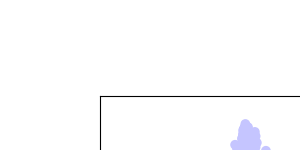

In [14]:
batch_size = 1024
epochs = 10
steps_per_epoch = int(x_train.shape[0]/batch_size)

net.compile(
    loss = triplet_loss(0.2, emb_size), 
    optimizer = 'adam'
)

%matplotlib notebook
_ = net.fit_generator(
    data_generator(batch_size, emb_size),
    steps_per_epoch = steps_per_epoch,
    epochs = epochs, 
    verbose = False,
    callbacks = [
        PCAPlotter(
            plt, 
            embedding_model,
            x_test[:1000], 
            y_test[:1000]
        )
    ]
)